# DC Gun Comparison

In [1]:
%pylab --no-import-all inline
%config InlineBackend.figure_format = 'retina'
import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pmd_beamphysics import ParticleGroup, single_particle, particle_paths
from pmd_beamphysics.labels import mathlabel
from pmd_beamphysics.units import pg_units
from pmd_beamphysics.plot import marginal_plot, density_plot

from distgen import Generator

from pytao import Tao

from impact import Impact

import h5py

## Parameters

In [3]:
GUN_PHASE_DEG = 0

## Initial Particle(s)

Pick one of these

In [4]:
# Single particle
P0 = single_particle(x=1000e-6, z=1e-9, pz=1e-9)

PFILE = 'initial_particles.h5'

In [5]:
DISTGEN_IN = """
n_particle: 1000
random_type: hammersley

start:
  type: cathode
  MTE:
    units: meV
    value: 250
    
total_charge:
  units: pC
  value: 50

r_dist:
  type: radial_uniform
  max_r:
    units: mm
    value: 0.5
  
t_dist:
  type: gaussian
  avg_t:
    units: ps
    value: 0
  sigma_t:
    units: ps
    value: 8.5
  n_sigma_cutoff: 3
  
"""
D = Generator(DISTGEN_IN)
D.run()
P0 = D.particles
P0

<ParticleGroup with 1000 particles at 0x7f66bc4bec40>

In [6]:
P0.write(PFILE)

In [7]:
for i in range(len(P0['status'])):
    P0['status'][i] = 1
P0.write('live_'+PFILE)

## Bmad

no space charge

In [8]:
tao = Tao(f'-init bmad/tao.init  -noplot -beam_init_position_file live_{PFILE}')

In [9]:
# Set the phase
tao.cmd(f'set ele GUN phi0 = {GUN_PHASE_DEG}/360')

[]

In [10]:
%%time
# Toggle beam
tao.cmd(f'set beam_init n_particle = {len(P0)}')
tao.cmd('set global track_type = beam')
tao.cmd('set global track_type = single')

CPU times: user 28 s, sys: 16.5 ms, total: 28 s
Wall time: 28.1 s


[]

In [11]:
# Gather particles
with h5py.File('beam_dump.h5', 'r') as h5:
    ppaths = particle_paths(h5)
    Plist = [ParticleGroup(h5[g]) for g in ppaths]
    
PfB1 = Plist[-1]

In [12]:
# Get the absolute phase used
a = tao.ele_gen_attribs('GUN')
field_scale =a['FIELD_AUTOSCALE']
field_scale

19516696.5348363

In [13]:
a = tao.ele_gen_attribs('GUN')
PHASE_DEG =(a['PHI0_AUTOSCALE'] + a['PHI0'])*360
PHASE_DEG

81.39510044712252

space charge

In [ ]:
tao = Tao(f'-init bmad/tao.init  -noplot -beam_init_position_file {PFILE}')

In [ ]:
%%time
# Toggle beam
tao.cmd('set bmad_com csr_and_space_charge_on = T')
tao.cmd(f'set beam_init n_particle = {len(P0)}')
tao.cmd('set global track_type = beam')
tao.cmd('set global track_type = single')

In [14]:
# Gather particles
with h5py.File('beam_dump.h5', 'r') as h5:
    ppaths = particle_paths(h5)
    Plist2 = [ParticleGroup(h5[g]) for g in ppaths]
    
PfB2 = Plist2[-1]

In [ ]:
tao = Tao(f'-init bmad/tao.init  -noplot -beam_init_position_file {PFILE}')

In [ ]:
%%time
# Toggle beam
tao.cmd('set ele GUN space_charge_method = cathode_fft_3d')
tao.cmd('set bmad_com csr_and_space_charge_on = T')
tao.cmd(f'set beam_init n_particle = {len(P0)}')
tao.cmd('set global track_type = beam')
tao.cmd('set global track_type = single')

In [19]:
# Gather particles
with h5py.File('beam_dump.h5', 'r') as h5:
    ppaths = particle_paths(h5)
    Plist3 = [ParticleGroup(h5[g]) for g in ppaths]
    
PfB3 = Plist3[-1]

## Impact-T

no space charge

In [16]:
%%time
I = Impact('impact/ImpactT-2D-dc.in', initial_particles=P0)

I.ele['APEX_gun']['theta0_deg'] = PHASE_DEG + 90
I.ele['APEX_gun']['rf_field_scale'] = field_scale
I.header['Bcurr'] = 0
I.run()
PfI1 = I.particles['final_particles']
PfI1.drift_to_z(0.2)

CPU times: user 107 ms, sys: 45.4 ms, total: 152 ms
Wall time: 3.09 s


space charge

In [17]:
%%time
I2 = Impact('impact/ImpactT-2D-dc.in', initial_particles=P0)

I2.ele['APEX_gun']['theta0_deg'] = PHASE_DEG + 90
I2.ele['APEX_gun']['rf_field_scale'] = field_scale
I2.run()
PfI2 = I2.particles['final_particles']
PfI2.drift_to_z(0.2) # to make the comparisons the same

CPU times: user 211 ms, sys: 49.7 ms, total: 260 ms
Wall time: 6min 24s


space charge + image charge

In [18]:
%%time
I3 = Impact('impact/ImpactT-2D-dc.in', initial_particles=P0)

I3.ele['APEX_gun']['theta0_deg'] = PHASE_DEG + 90
I3.ele['APEX_gun']['rf_field_scale'] = field_scale
I3.header['Zimage'] = 0.05
I3.run()
PfI3 = I3.particles['final_particles']
PfI3.drift_to_z(0.2)

CPU times: user 250 ms, sys: 38.4 ms, total: 288 ms
Wall time: 10min 47s


## Compare Stats

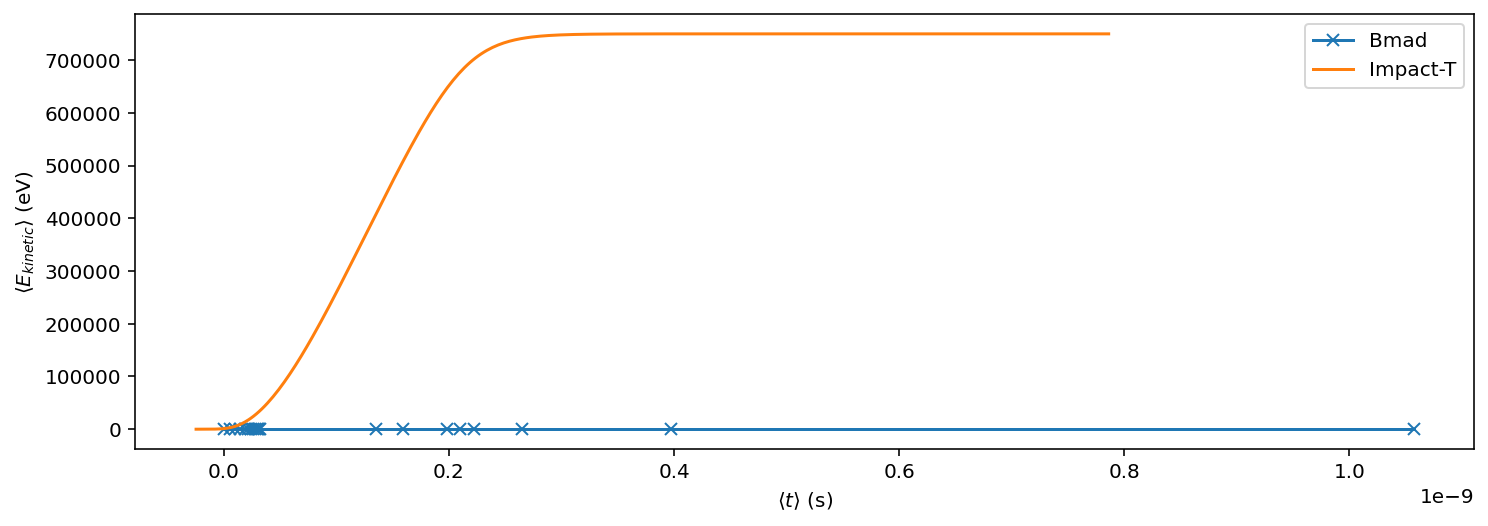

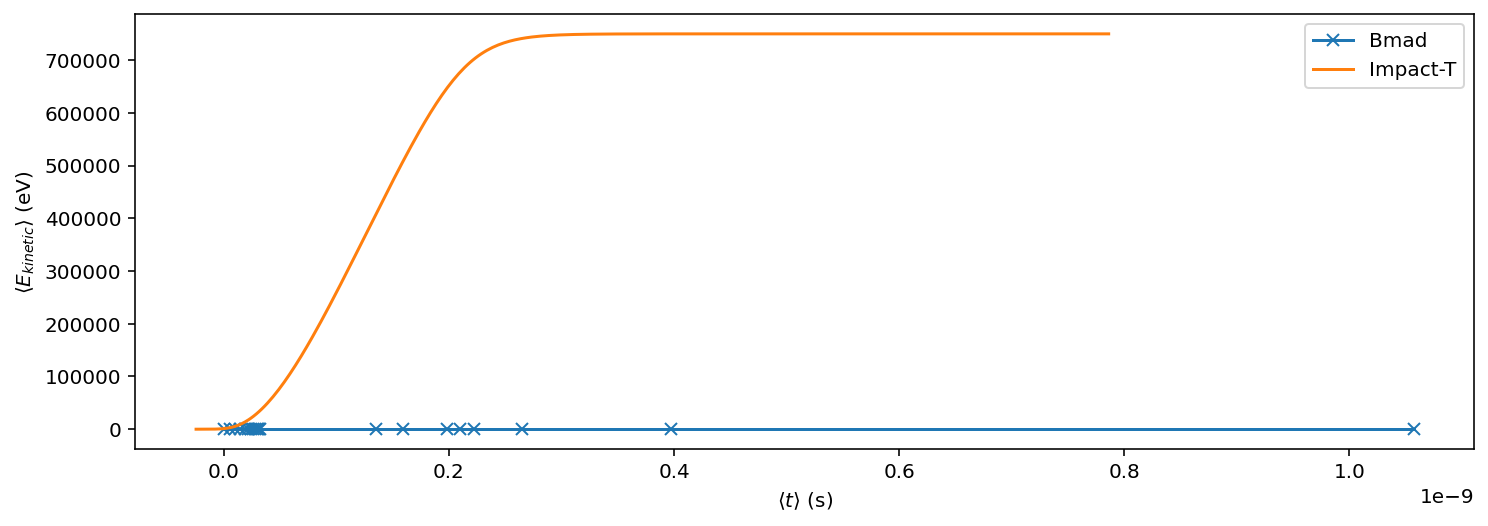

In [16]:
def compare_stat(key):

    fig, ax = plt.subplots(figsize=(12,4))
    
    ky = key
    
    kx = 'mean_t'
    bmadx = np.array([P[kx] for P in PAlist])   
    bmady = np.array([P[ky] for P in PAlist])
    
    ax.plot(bmadx, bmady, label='Bmad', marker='x')
    #ax.plot(I.stat('t'), I.stat(ky), label='no sc')
    ax.plot(I.stat('t'), I.stat(ky), label='Impact-T')
    
    ax.set_ylabel(mathlabel(ky, units=pg_units(ky)))
    ax.set_xlabel(mathlabel(kx, units=pg_units(kx)))
    plt.legend()
    return fig
    
compare_stat('mean_kinetic_energy')


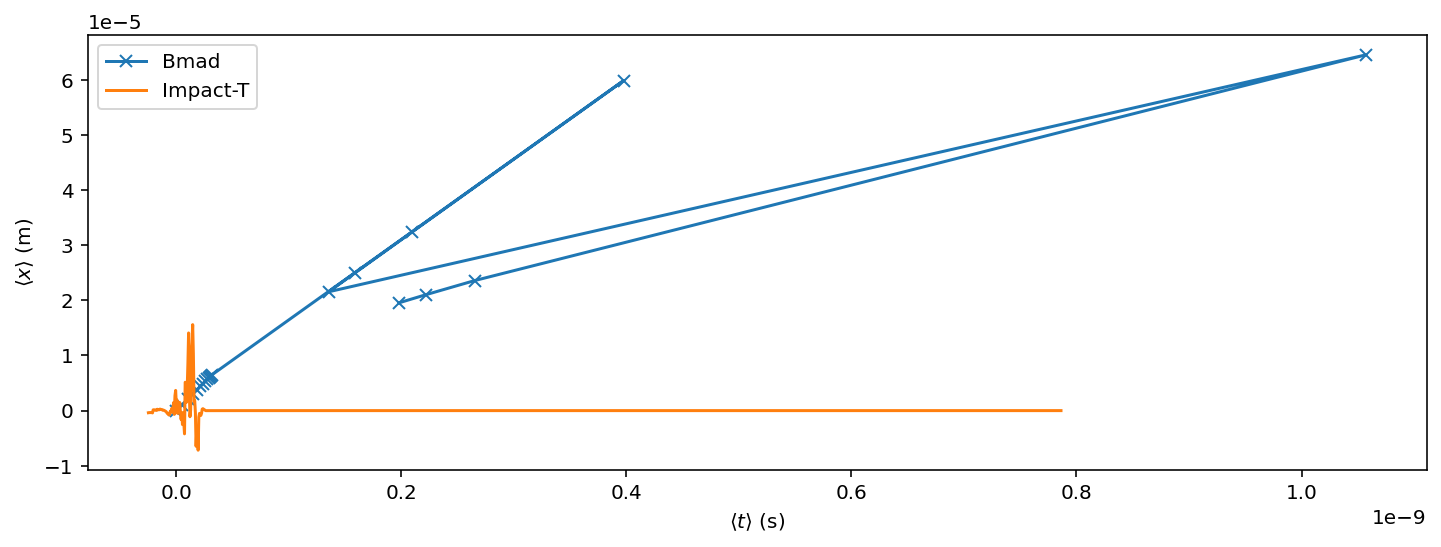

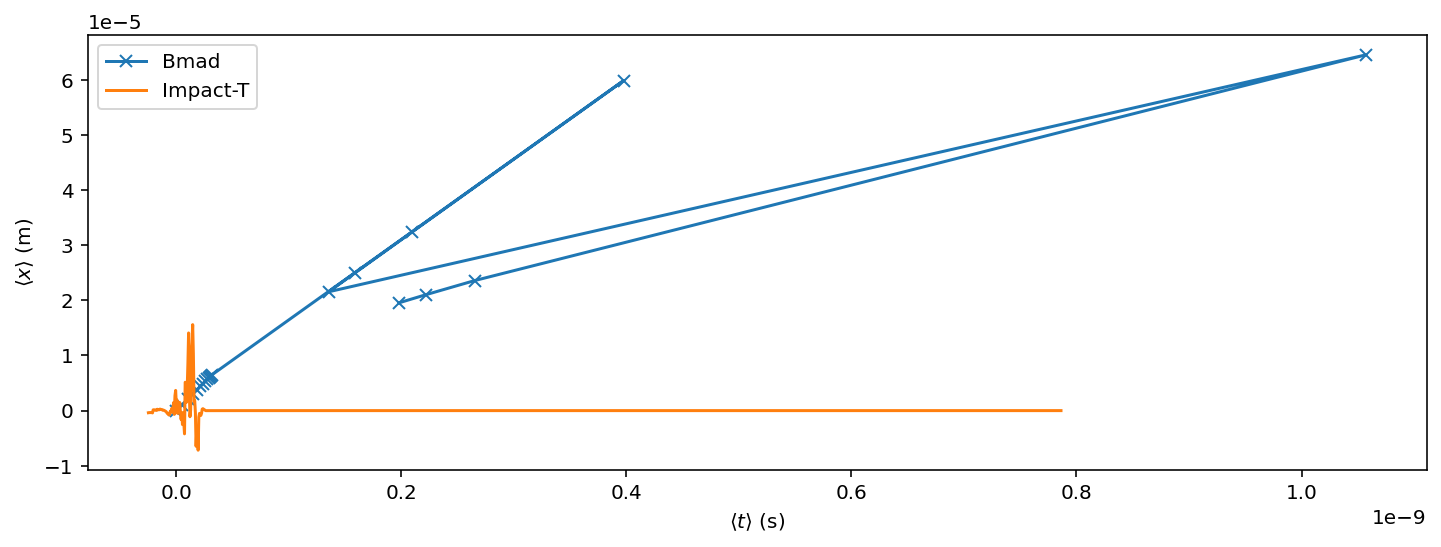

In [17]:
compare_stat('mean_x')

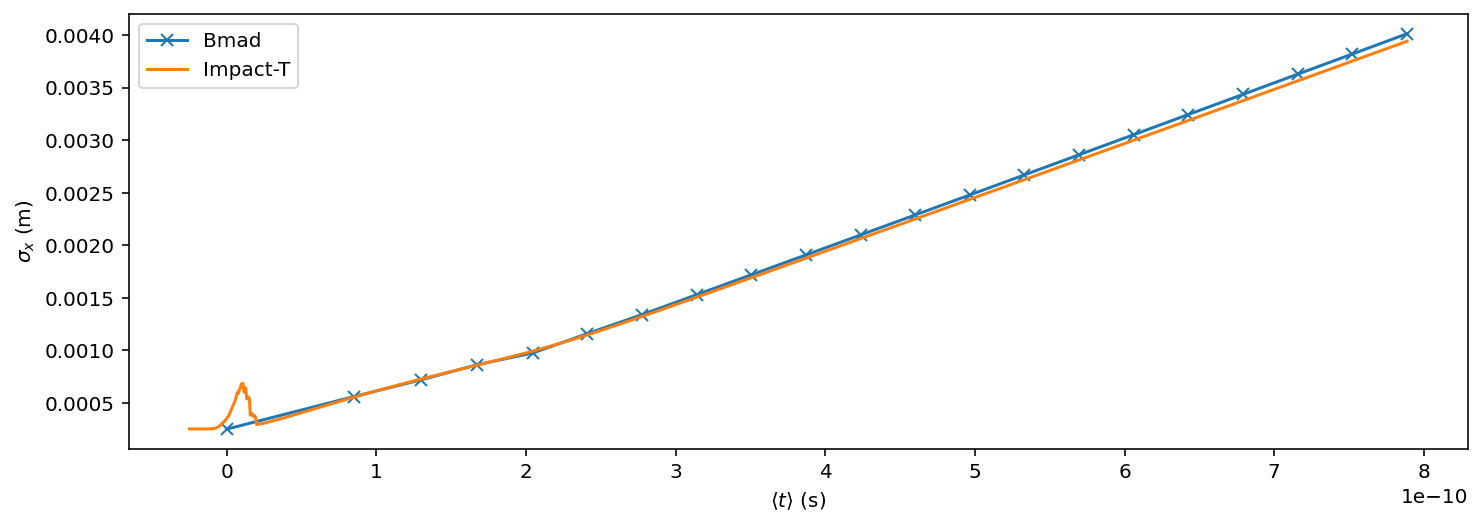

In [60]:
fig = compare_stat('sigma_x')  

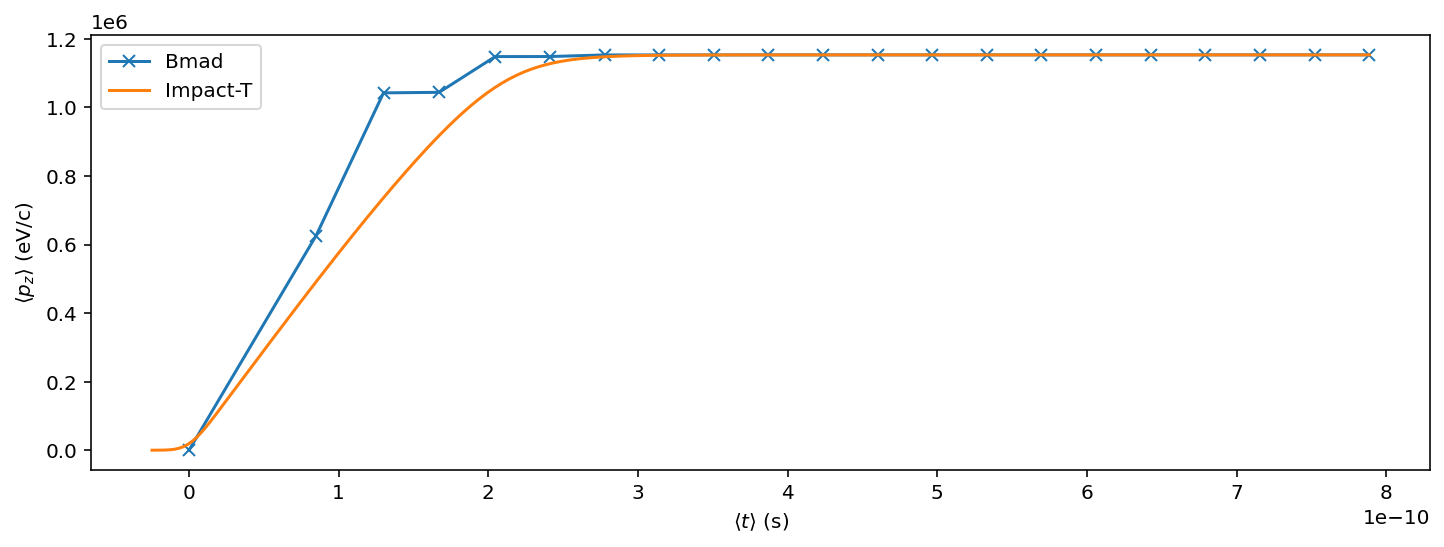

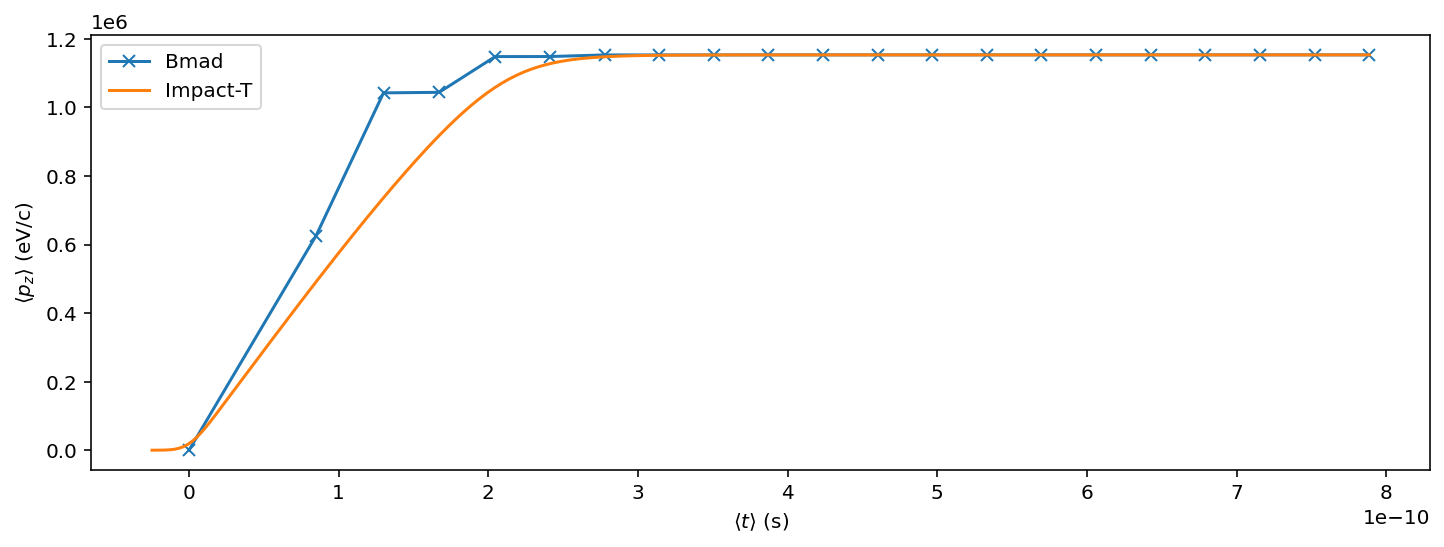

In [61]:
compare_stat('mean_pz')

## Compare final particles

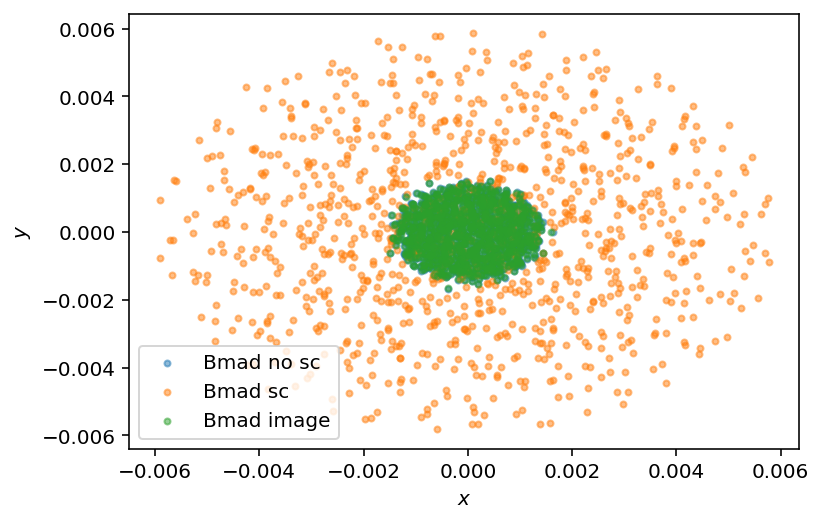

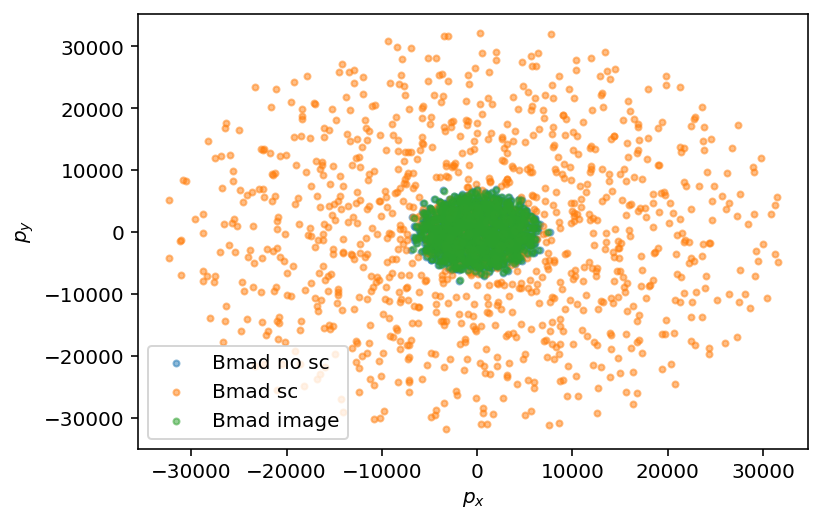

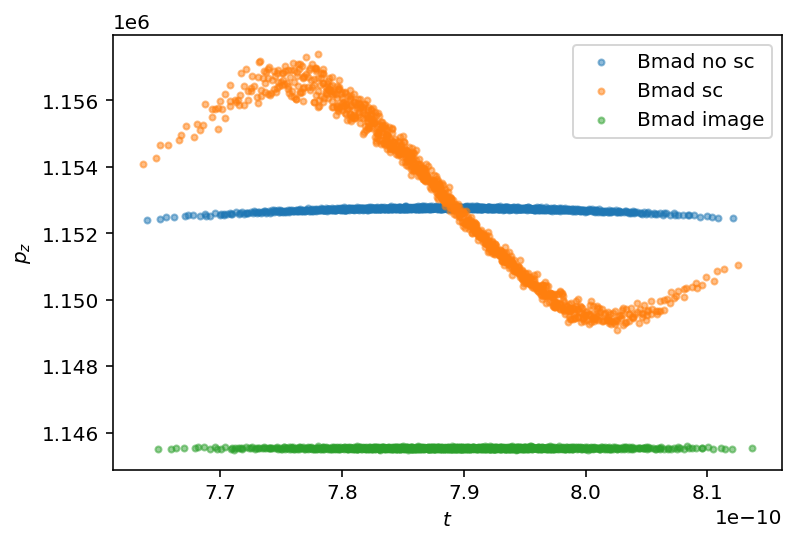

In [23]:
def compare_particles(k1, k2):
    
    plist=(PfB1, PfB2, PfI1)
    labels=('Bmad no sc', 'Bmad sc', 'Bmad image')
    markers=('.','.','.')
    
    fig, ax = plt.subplots()
    for P, label, marker in zip(plist, labels, markers):
        ax.scatter(P[k1], P[k2], marker=marker, label=label, alpha = 0.5)
        
    ax.set_xlabel(mathlabel(k1))
    ax.set_ylabel(mathlabel(k2))
    plt.legend()
    #plt.savefig(k1+'_'+k2+'.png')
    
compare_particles('x', 'y')

compare_particles('px', 'py')

compare_particles('t', 'pz')

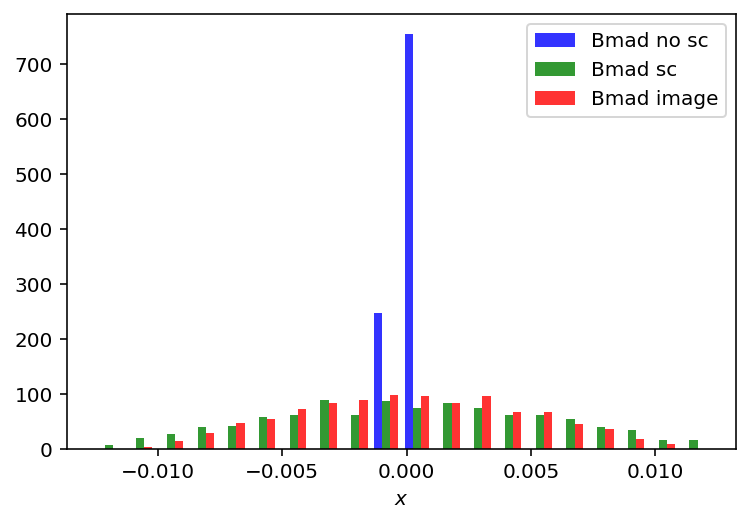

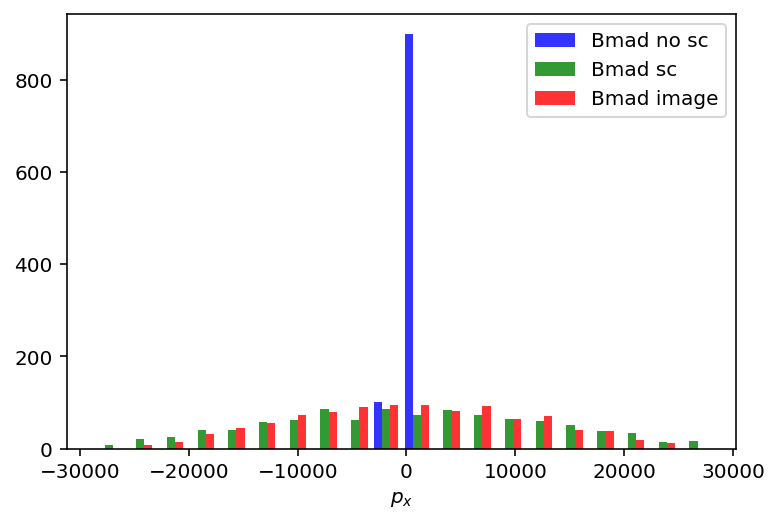

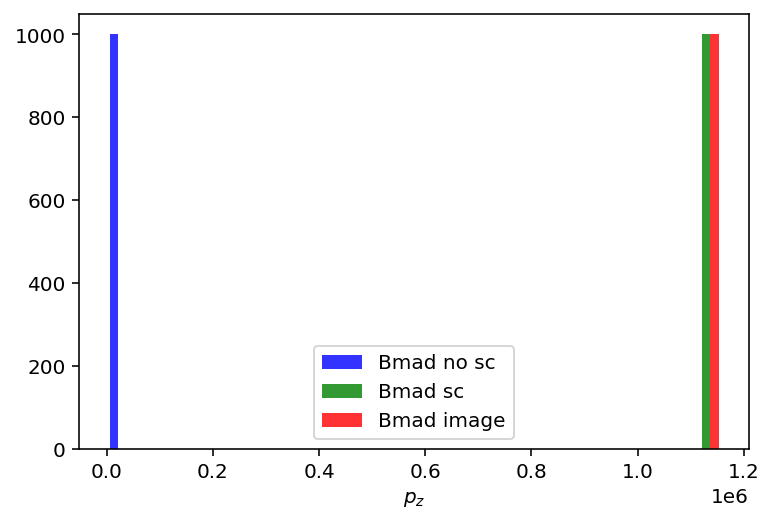

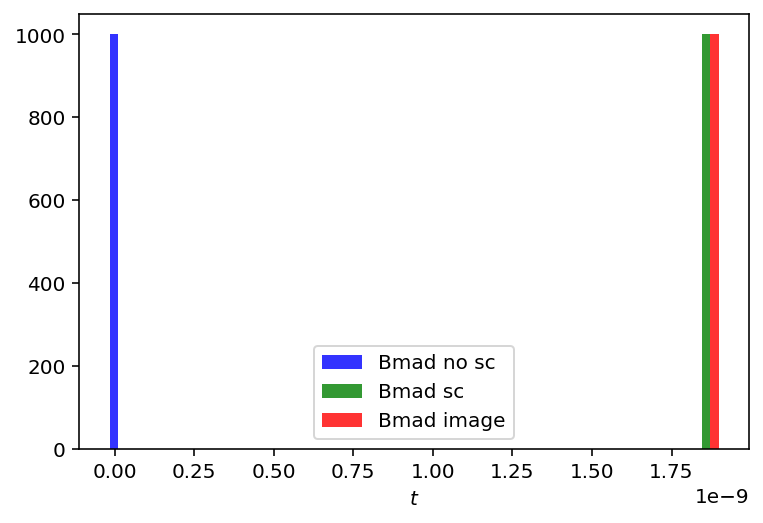

In [34]:
def compare_particles_hist(k1):
    
    plist=(PfB,PfA1,PfA2)
    labels=('Bmad no sc', 'Bmad sc', 'Bmad image')
    colors = ('b','g','r')
    
    fig, ax = plt.subplots()
    data = list()
    for P in plist:
        data.append(P[k1])
    
    ax.hist(data, bins=20, label=labels, color=colors, alpha = 0.8)
        
    ax.set_xlabel(mathlabel(k1))
    
    plt.legend()
    #plt.savefig(k1+'_hist'.png')
    
compare_particles_hist('x')
compare_particles_hist('px')
compare_particles_hist('pz')
compare_particles_hist('t')

In [185]:
# Cleanup
!rm beam_dump.h5
!rm initial_particles.h5
!rm live_initial_particles.h5